In [4]:
pip install -qq diffusers datasets accelerate wandb open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from torchvision import transforms
from tqdm.auto import tqdm
import pandas as pd
import os
import re

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

#downloading model + testing

In [6]:
from diffusers import StableDiffusionPipeline

model_id = "prompthero/openjourney-v4"
pipeline = StableDiffusionPipeline.from_pretrained(model_id)
pipeline.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.53k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.1",
  "_name_or_path": "prompthero/openjourney-v4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
prompt = "Frosty creature with white fur and green accents, resembling a snowman, large arms, and playful demeanor, set against a whimsical, snowy backdrop."
image = pipeline(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

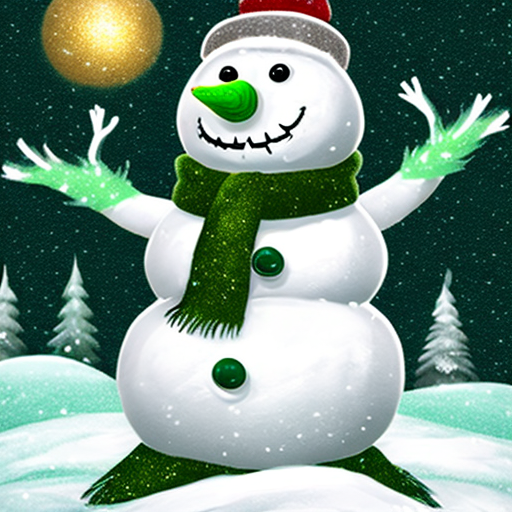

In [8]:
image.save("base_model.png")
image

# finetuning

In [9]:
!git init
!git remote add origin https://github.com/ali-vayani/PokeGen.git
!git sparse-checkout init --no-cone
!git sparse-checkout set Data
!git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 1053, done.
remote: Counting objects: 100% (1053/1053), done.
remote: Compressing objects: 100% (1046/1046), done.
remote: Total 1053 (delta 11), reused 1036 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (1053/1053), 16.49 MiB | 34.39 MiB/s, done.
Resolving deltas: 100% (11/11), done.
From https://github.com/ali-vayani/PokeGen
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [10]:
class PokemonDataset(Dataset):
  def __init__(self, csv_file, image_folder, transform=None):
    self.data = pd.read_csv(csv_file)
    self.image_folder = image_folder
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_name = os.path.join(self.image_folder, str(self.data.iloc[idx, 1])[15:])
    label = re.sub(r'[^a-zA-Z\s]', '', self.data.iloc[idx, 4].lower().replace("\"", ""))

    image = Image.open(img_name).convert("RGB")

    if self.transform:
      image = self.transform(image)

    return image, label

In [11]:
def add_noise(img, noise_level=0.05):
  noise = torch.randn_like(img) * noise_level
  return (img + noise).clamp(0, 1)

#def replace_background(image, replacement_color=(255, 255, 255)):
#    image = image.convert("RGBA")
#    mask = ImageOps.invert(ImageOps.grayscale(image)).point(lambda x: 0 if x > 240 else 255, mode="1")
#    background = Image.new("RGBA", image.size, replacement_color + (255,))
#    composite = Image.alpha_composite(background, image).convert("RGB")
#    return composite

preprocess = transforms.Compose(
  [
    #transforms.Lambda(lambda img: replace_background(img, replacement_color=(127, 127, 127))),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: add_noise(img, noise_level=0.05)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
  ]
)

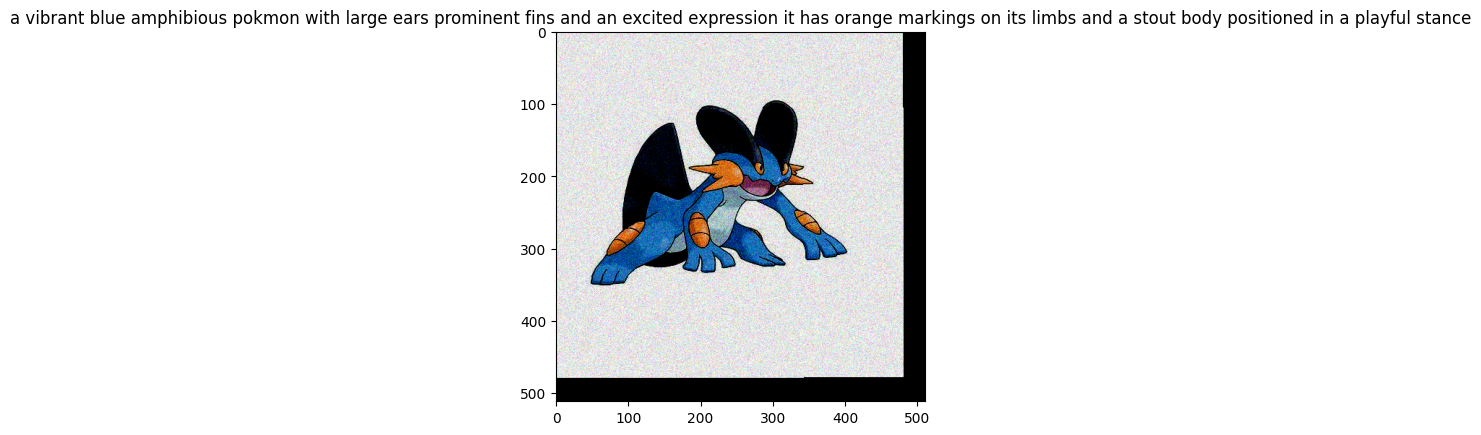

In [31]:
# ipython-input-26-5f651399ac87

image_path = 'Data/pokemon_images'
csv_path = 'Data/pokemon_data.csv'
image_size = 512
batch_size = 1

dataset = PokemonDataset(csv_path, image_path, transform=preprocess)

def custom_collate(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, labels

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

for images, labels in dataloader:
    plt.imshow(images[0].permute(1, 2, 0))  # Permute for HWC format
    plt.title(labels[0])
    plt.show()
    break

In [13]:
num_epochs = 2
lr = 1e-5
grad_acc_steps = 2

optimizer = torch.optim.AdamW(pipeline.unet.parameters(), lr=lr)
losses = []

In [32]:
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

pipeline.to(device)
#pipeline.train()

losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        clean_images = batch[0].to(device)
        prompts = batch[1]
        noise = torch.randn_like(clean_images)  # Generate noise
        bs = clean_images.shape[0]

        # Encode prompts using CLIP text encoder
        text_inputs = pipeline.tokenizer(prompts, return_tensors="pt", padding=True).input_ids.to(device)
        text_embeddings = pipeline.text_encoder(text_inputs)[0]

        # Sample random timesteps
        timesteps = torch.randint(
            0,
            pipeline.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device
        ).long()

        # Add noise to the images
        scaling_factor = torch.sqrt(1 - pipeline.scheduler.alphas_cumprod.to(timesteps.device)[timesteps])
        scaling_factor = scaling_factor.view(-1, 1, 1, 1)  # Reshape to match image dimensions
        noisy_images = clean_images + noise * scaling_factor

        # Convert noisy images to latent space
        latents = pipeline.vae.encode(noisy_images).latent_dist.sample()
        latents = latents * pipeline.vae.config.scaling_factor

        # Predict noise using the UNet
        noise_pred = pipeline.unet(latents, timesteps, encoder_hidden_states=text_embeddings, return_dict=False)[0]


        # Compute loss
        loss = F.mse_loss(noise_pred, noise)
        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()

        if (step + 1) % grad_acc_steps == 0 or step == len(train_dataloader) - 1:
            optimizer.step()
            optimizer.zero_grad()
            torch.save(pipeline.state_dict(), f"model_epoch_{epoch+1}.pt")

    # Record average epoch loss
    avg_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

# Plot losses
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss")
plt.show()


  0%|          | 0/1021 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
  0%|          | 0/1021 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 11694 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for epoch in range(num_epochs):
  for step, batch, in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    clean_images = batch["images"].to(device)
    noise = torch.randn(clean_images.shape).to(clean_images.device)
    bs = clean_images.shape[0]

    timesteps = torch.randint(
        0,
        pipeline.scheduler.num_train_timesteps,
        (bs,),
        device = clean_images.device
    ).long()

    noisy_images = pipeline.scheduler.add_noise(clean_images, noise, timesteps)
    noise_pred = pipeline.unet(noisy_images, timesteps, return_dict=False)[0]

    loss = F.mse_loss(
        noise_pred, noise
    )

    losses.append(loss.item())

    loss.backward(loss)

    if (step + 1) % grad_acc_steps == 0:
      optimizer.step()
      optimizer.zero_grad()
  print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")
plt.plot(losses)